In [10]:
import torch
import torch.nn as nn
from torchvision import transforms 
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(0)

In [11]:
def show_tensor_images(image_tensor, num_images = 25, size = (1, 28, 28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, im_chan = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size = 4, stride = 1),
            self.make_gen_block(hidden_dim*2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size = 4, final_layer = True))
        
    
    def make_gen_block(self, in_chan, out_chan, kernel_size = 3, stride = 2, final_layer = False):
        
        if not final_layer:
            
            return nn.Sequential(
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(out_chan),
                nn.ReLU())
        else:
            
            return nn.Sequential(
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size = kernel_size, stride = stride),
                nn.Tanh())
    
    def unsqueeze_noise(self, noise):
        
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        
        x = self.unsqueeze_noise(noise)
        
        return self.gen(x)
    
    
    
def get_noise(n_samples, z_dim, device = 'cpu'):
        
    return torch.randn(n_samples, z_dim, device = device)

        

torch.Size([100, 1, 28, 28])


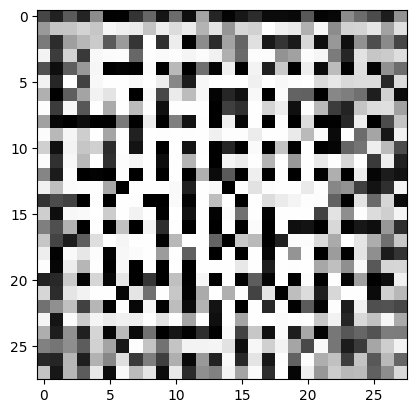

In [17]:
gen = Generator()
n_samples = 100
noise = get_noise(n_samples, gen.z_dim)
unsqueeze = gen.unsqueeze_noise(noise)
gen_out = gen(unsqueeze)
print(gen_out.shape)
show_tensor_images(gen_out, 1)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, im_chan = 1, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
                    self.make_disc_block(im_chan, hidden_dim),
                    self.make_disc_block(hidden_dim, hidden_dim*2),
                    self.make_disc_block(hidden_dim*2, 1, final_layer = True))
        
    def make_disc_block(self, in_chan, out_chan, kernel_size = 4, stride = 2, final_layer = False):
        
        if not final_layer:
            
            return nn.Sequential(nn.Conv2d(in_chan, out_chan, kernel_size = kernel_size, stride = stride),
                                 nn.BatchNorm2d(out_chan),
                                 nn.LeakyReLU(0.02))
        else:
            
            return nn.Sequential(nn.Conv2d(in_chan, out_chan, kernel_size = kernel_size, stride = stride))
        
    def forward(self, image):
        
        disc_pred = self.disc(image)
        
        return disc_pred.view(len(disc_pred), -1)
    

In [ ]:
n_samples = 100
gen = Generator()
noise = get_noise(n_samples, gen.z_dim)
fake_image = gen(noise)
print(fake_image.shape)

disc = Discriminator()
disc_out = disc(fake_image)
print(disc_out.shape)

In [19]:
criterion = nn.BCEWithLogitsLoss()

In [6]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    
    noise = get_noise(num_images, z_dim).to(device)
    fake_img = gen(noise).detach()
    
    disc_fake_pred = disc(fake_img)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    
    disc_loss = (disc_real_loss + disc_fake_loss)/2.0
    
    return disc_loss
    

In [7]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    
    noise = get_noise(num_images, z_dim)
    fake_img = gen(noise)
    
    disc_pred = disc(fake_img)
    
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    
    return gen_loss

In [20]:
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataloader = DataLoader(dsets.MNIST('./data',  download = True, transform = transform), batch_size = batch_size, 
            shuffle = True)                           

In [21]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.9283173167705538, discriminator loss: 0.48630485147237734


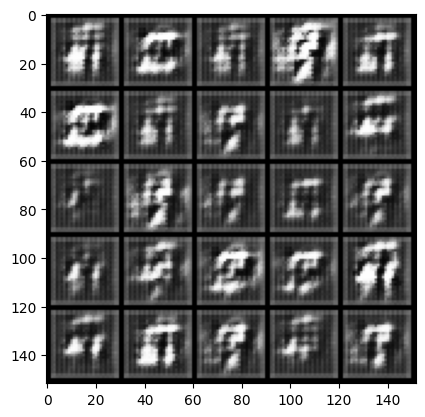

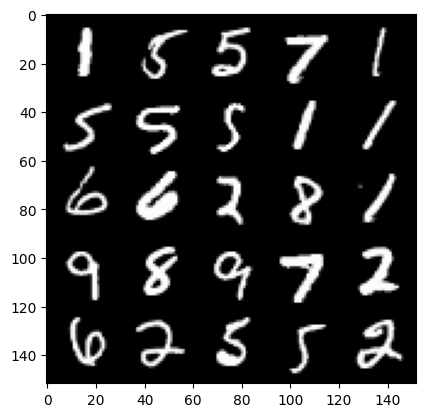

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.0027264360189436, discriminator loss: 0.5597349549531939


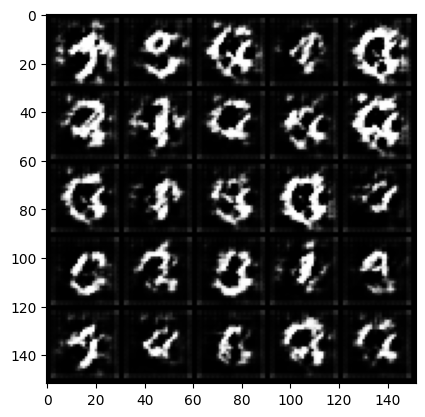

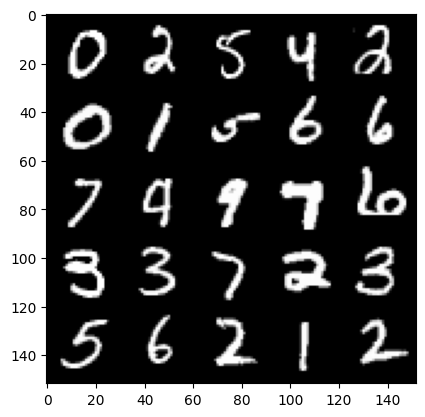

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 0.8639307258129113, discriminator loss: 0.6013532265424729


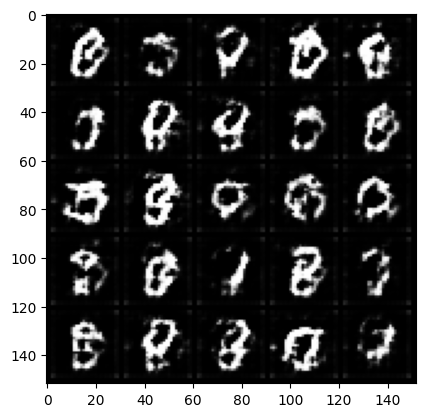

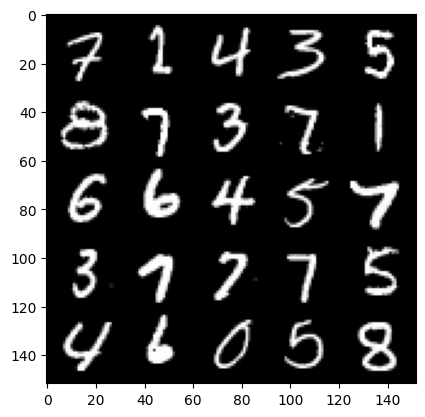

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 0.8501981132030487, discriminator loss: 0.616351744651795


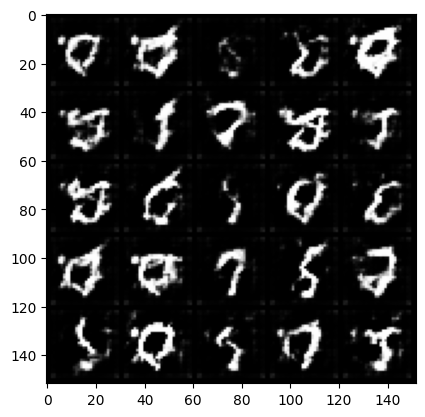

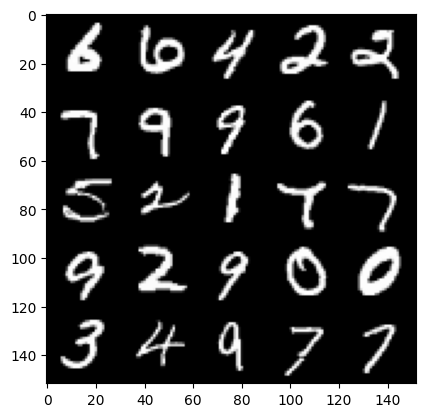

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.8146635866165161, discriminator loss: 0.6361203184127812


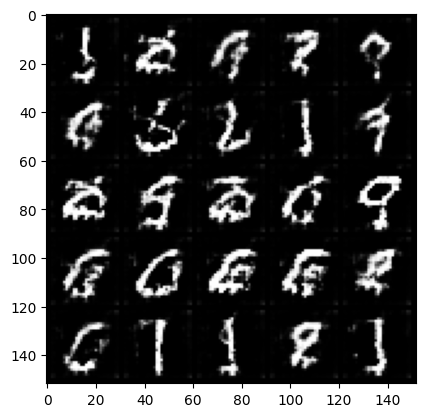

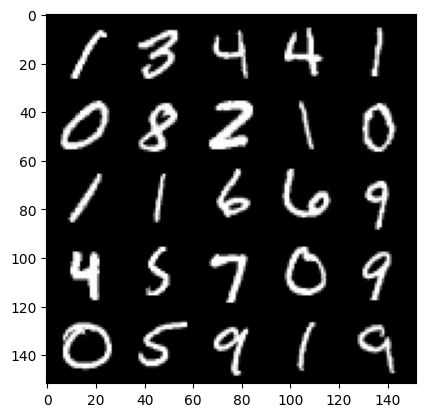

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.7876017476320276, discriminator loss: 0.6557666447162628


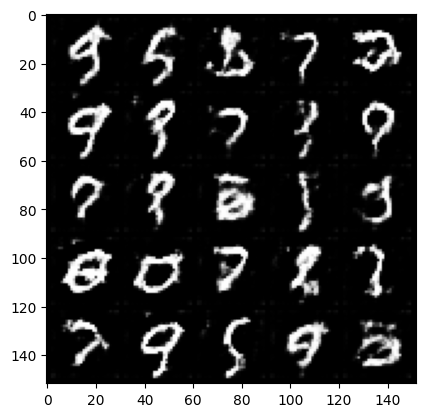

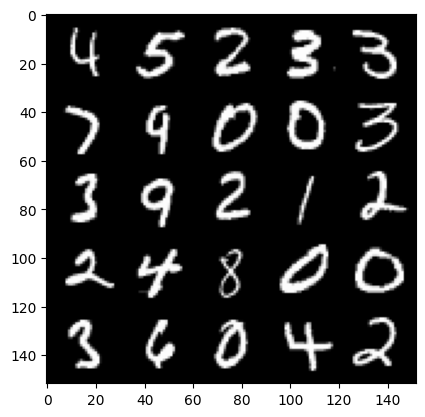

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.7682126634120947, discriminator loss: 0.6572907975912097


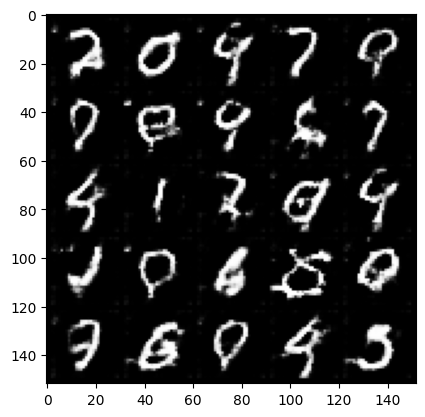

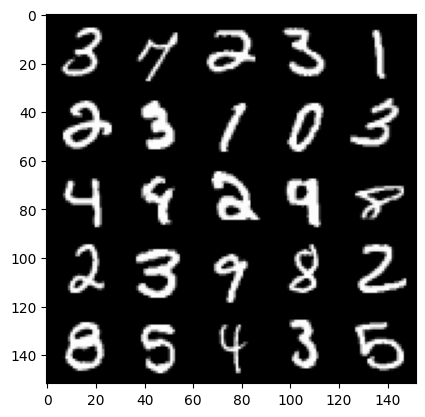

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.7654020937681194, discriminator loss: 0.6629658293724054


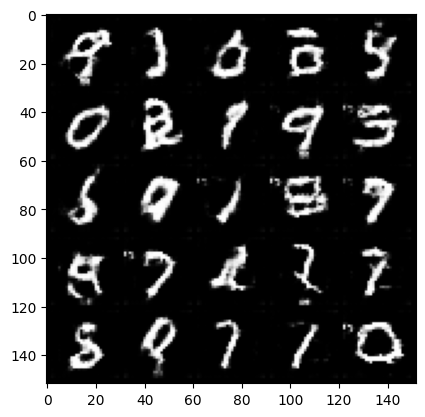

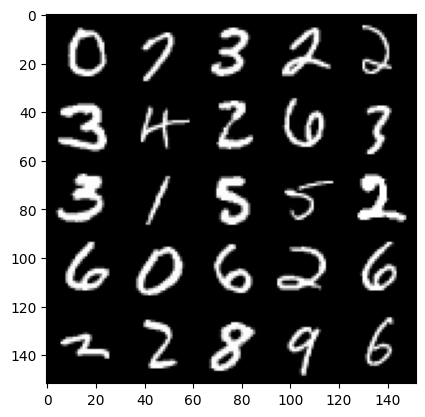

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.7553618190288554, discriminator loss: 0.6631017059087757


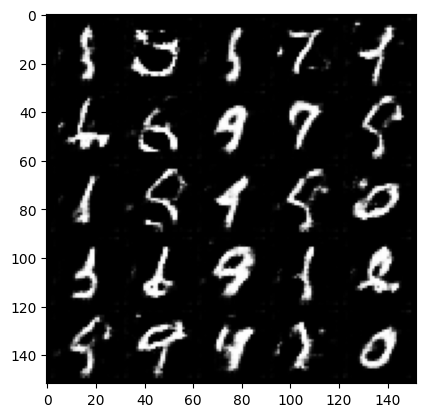

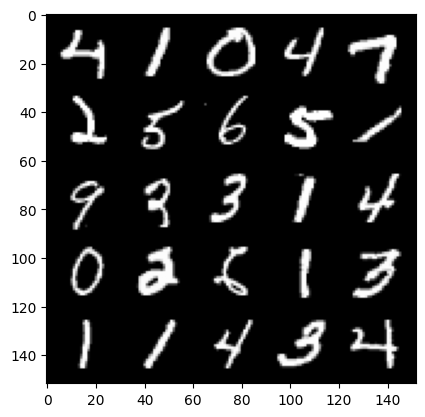

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.7535790626406668, discriminator loss: 0.665067326545716


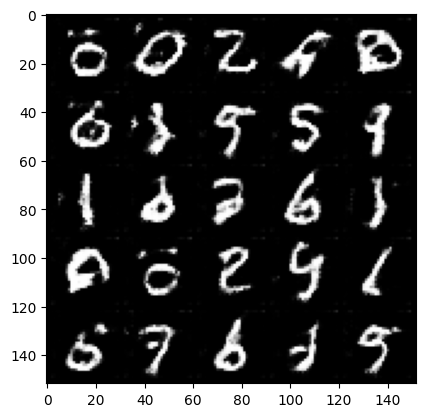

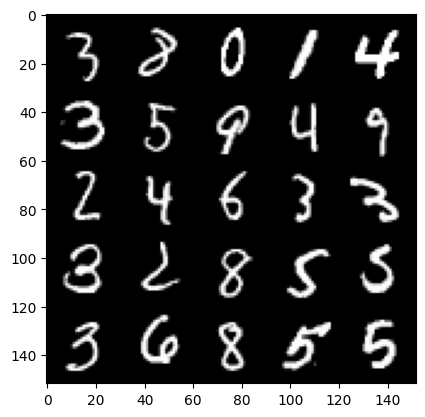

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.7510024402141575, discriminator loss: 0.6675673666000362


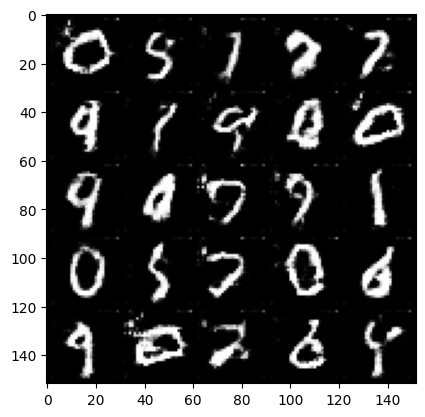

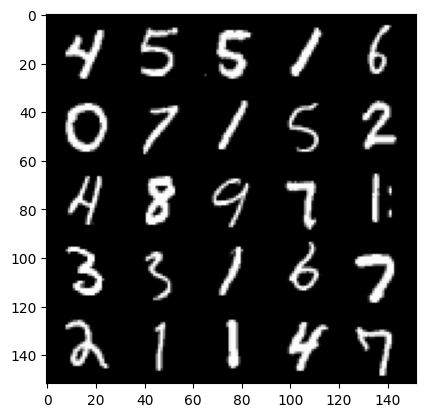

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.7470983742475519, discriminator loss: 0.6688612769842149


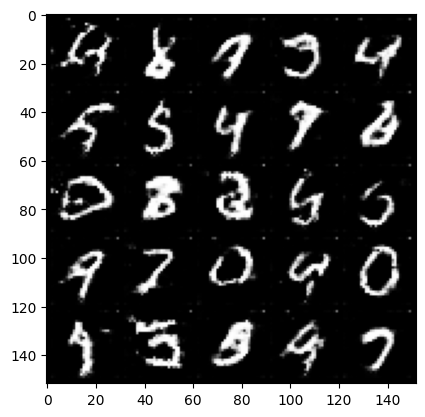

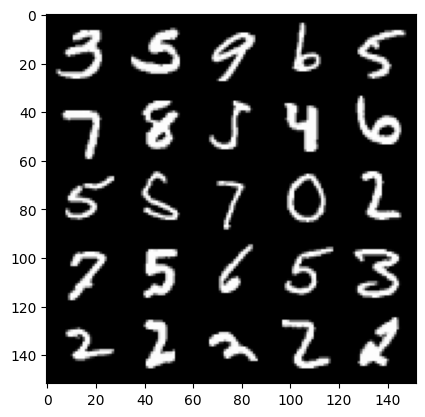

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.7492499977350231, discriminator loss: 0.670095807671547


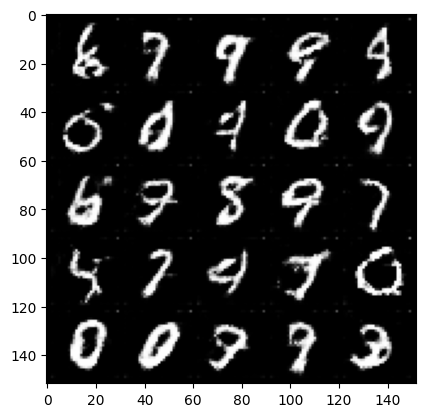

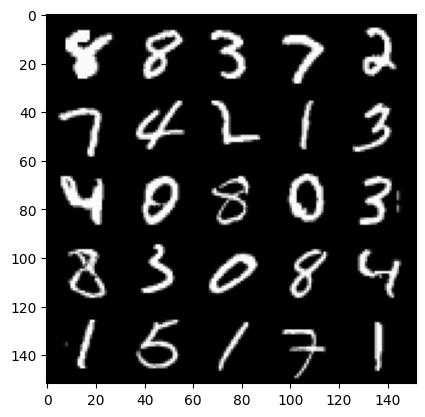

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    
    for real, _ in tqdm(dataloader):
        
        cur_batch_size = len(real)
        
        real = real.to(device)
        
        disc_opt.zero_grad()
        
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        
        disc_loss.backward(retain_graph = True)
        disc_opt.step()
        
        mean_discriminator_loss += disc_loss.item()/display_step
        
        
        gen_opt.zero_grad()
        
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        
        
        gen_loss.backward(retain_graph = True)
        gen_opt.step()
        
        mean_generator_loss += gen_loss.item()/display_step
        
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
        
        
        